# Comparing Explainability Methods Under a White Box Model
This is a "fluorescent test," conducted under laboratory conditions with fluorescent lighting. In this test, we will generate synthetic data with known dynamics for the response variable. Next, we will calculate global explanations using various explainability methods and compare them against the ground truth.

In [1]:
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_regression

from explainer_comparison.ExplainerFactory import ExplainerFactory
from explainer_comparison.explainer_utilities import run_and_collect_explanations
from explainer_comparison.white_box_model.white_box import WhiteBoxRegressor
from explainer_comparison.explainers_evaluation import evaluate_explainers, permutation_feature_importance, plot_feat_importance, evaluate_mse


import seaborn as sns
from matplotlib import pyplot as plt
import numpy as np


In [2]:
# import sys
# sys.path

## Generate a White-Box Model and Data

In [3]:
# model = WhiteBoxRegressor()
# df = model.generate_synthetic_data(n_samples=1000, with_y=True)
# X, y = df.drop(['y'], axis=1), df[['y']]

In [4]:
n_samples = 1000
n_features = 10
feature_columns = [f'f_{i+1}' for i in range(n_features)]

X, y = make_regression(n_samples=n_samples, n_features=n_features, n_informative=n_features, noise=0, random_state=42)
X = pd.DataFrame(X, columns=feature_columns)
y = pd.DataFrame(y, columns=['target'])

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

In [6]:
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

## Visualize Features and Target

<Axes: >

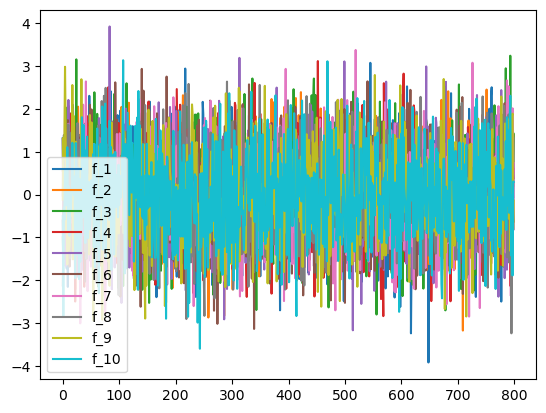

In [7]:
X_train.plot()

<Axes: >

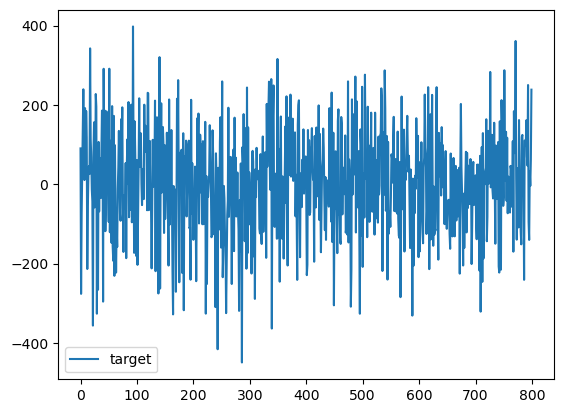

In [8]:
y_train.plot()

## Calculate SHAP and LIME explanation and Compare to Ground Truth

In [9]:
explainer_factory = ExplainerFactory(model, X_train, X_test, y_train, y_test)
results = run_and_collect_explanations(explainer_factory, X_train)
results['ground_truth'] = (X_train * model.coef_).mean()


 SHAP explanation created

 LIME explanation created

 EBM explanation created


In [10]:
results

,SHAP Value,LIME Value,EBM Value,ground_truth
f_1,-3.448388,-0.064313,23.691487,0.208801
f_2,5.895924,0.467090,54.457760,3.056305
f_3,5.397595,0.226621,26.091087,0.571549
f_4,-0.661504,0.422173,7.110801,-0.572624
f_5,0.258134,0.345474,4.656930,-0.161036
f_6,3.861633,-0.818545,44.427392,0.526350
f_7,1.236633,-0.542281,22.249731,-0.526185
f_8,0.554420,-0.137551,5.087899,-0.204574
f_9,0.765929,0.244963,8.750027,0.262747
f_10,12.716707,0.021073,59.206309,-1.133059


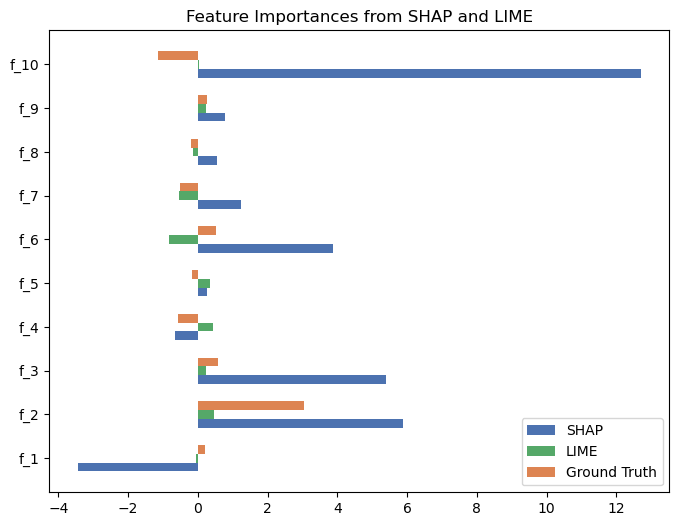

In [11]:
colors = sns.color_palette("deep")
plt.figure(figsize=(8, 6))

bar_positions = np.arange(len(results))  # Positions of the bars
bar_width = 0.2  # Adjust bar width to fit all bars

# Plotting the bars with adjusted positions
plt.barh(bar_positions - bar_width, results['SHAP Value'], height=bar_width, label='SHAP', color=colors[0])  # SHAP values
plt.barh(bar_positions, results['LIME Value'], height=bar_width, label='LIME', color=colors[2])  # LIME values
plt.barh(bar_positions + bar_width, results['ground_truth'], height=bar_width, label='Ground Truth', color=colors[1])  # Ground Truth values

plt.yticks(bar_positions, results.index)  #labels

plt.title('Feature Importances from SHAP and LIME')
plt.legend()
plt.show()

## Calculate permutation feature importance

In [12]:
feature_importances = permutation_feature_importance(model, X_test, y_test, metric='mse', random_state=42)

feature_importances_df = pd.DataFrame.from_dict(feature_importances, orient='index', columns=['importance'])
feature_importances_df = feature_importances_df.sort_values(by='importance', ascending=False)

feature_importances_df

,importance
f_5,-68.634491
f_8,-87.017060
f_4,-178.040079
f_9,-267.845198
f_7,-1768.743535
f_3,-2103.830061
f_1,-2228.480510
f_6,-6631.709924
f_2,-10146.336844
f_10,-11543.593040


In [13]:
import matplotlib.pyplot as plt

def plot_results(df):

    max_importance = df['importance'].max()
    std_importance = df['importance'].std()

    # Apply z-score normalization to the 'importance' column
    df['importance'] = (df['importance'] - max_importance) / std_importance

    fig, ax = plt.subplots(figsize=(12, 6))

    df.plot(kind='bar', ax=ax)
    ax.set_ylabel('Value')
    ax.set_xlabel('Feature')
    ax.set_title('SHAP, LIME, and Importance Values for Features')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

def plot_mse(shap_mse_values, lime_mse_values):
    # Plot the MSE values
    plt.figure(figsize=(10, 6))
    plt.plot(shap_mse_values, label='SHAP MSE')
    plt.plot(lime_mse_values, label='LIME MSE')
    plt.xlabel('Iteration')
    plt.ylabel('MSE')
    plt.title('Stability of SHAP and LIME Values')
    plt.legend()
    plt.grid(True)
    plt.show()

## Evaluate the consistency of SHAP and LIME

In [14]:
results = evaluate_explainers(model, X_test, y_test, metric='mse', threshold=0.3, random_state=42, verbose=False, explainers=['shap', 'lime'])

In [24]:
results[0]['importance'].abs().idxmin()

'f_5'

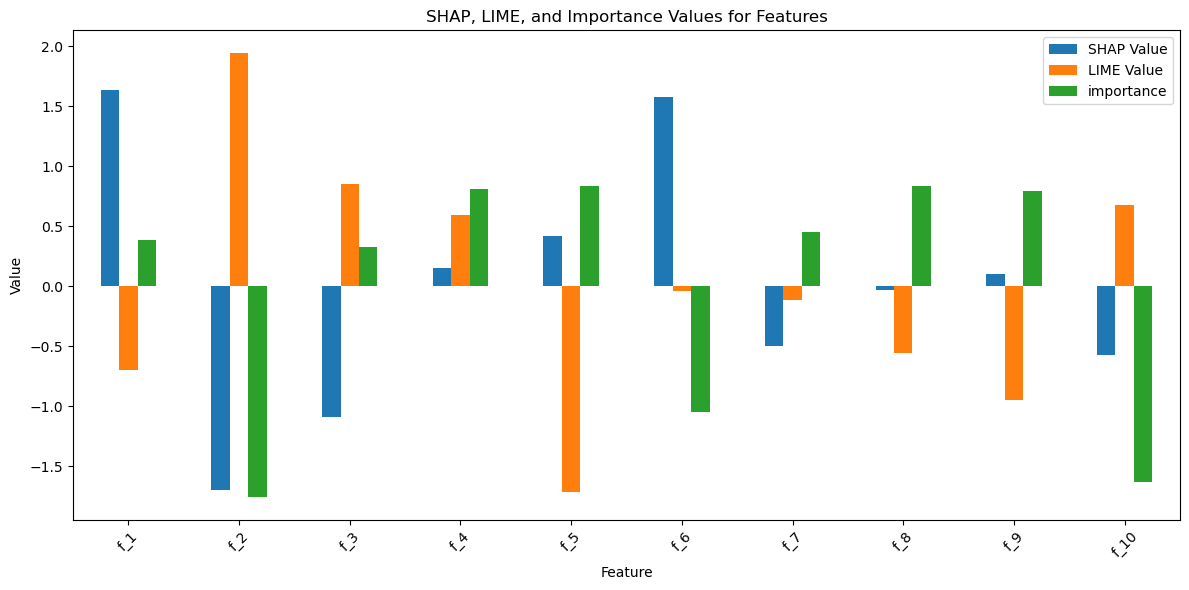

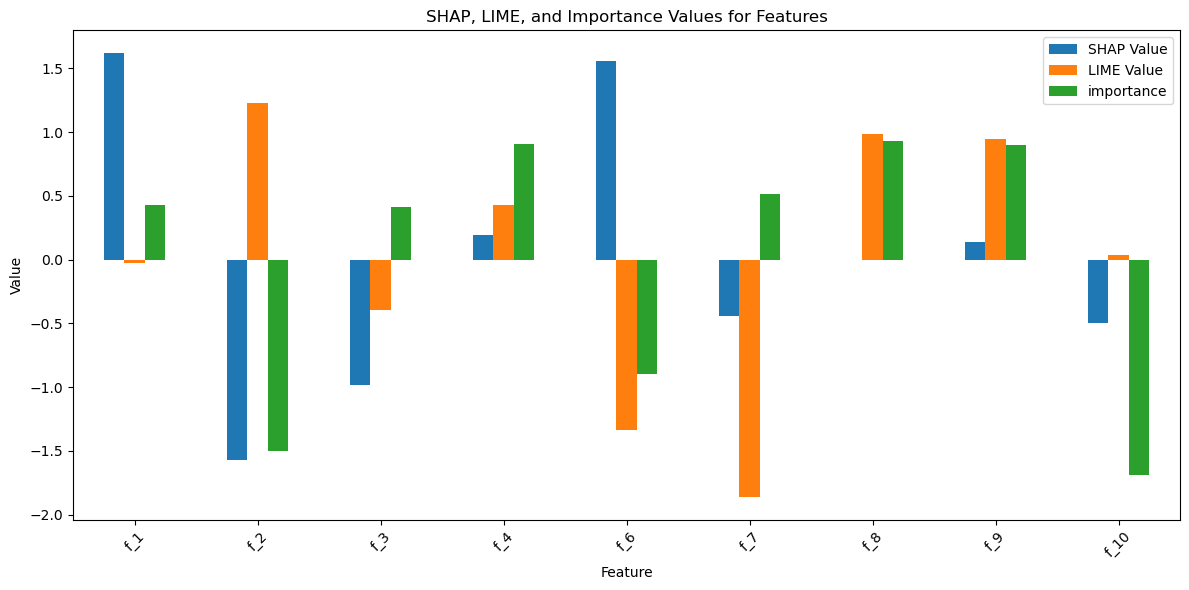

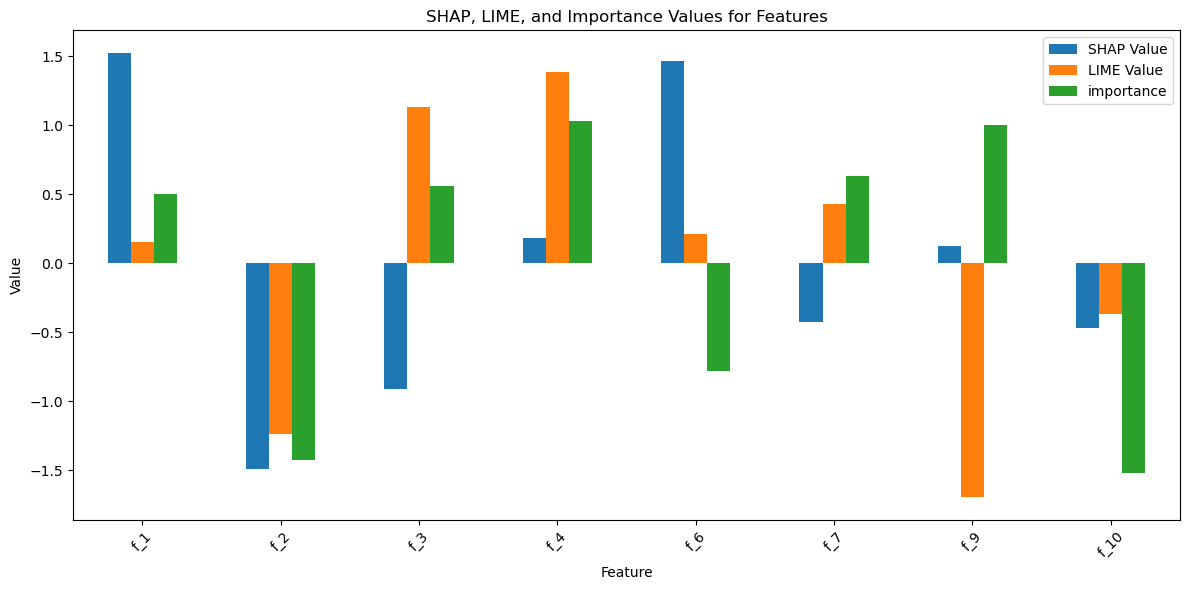

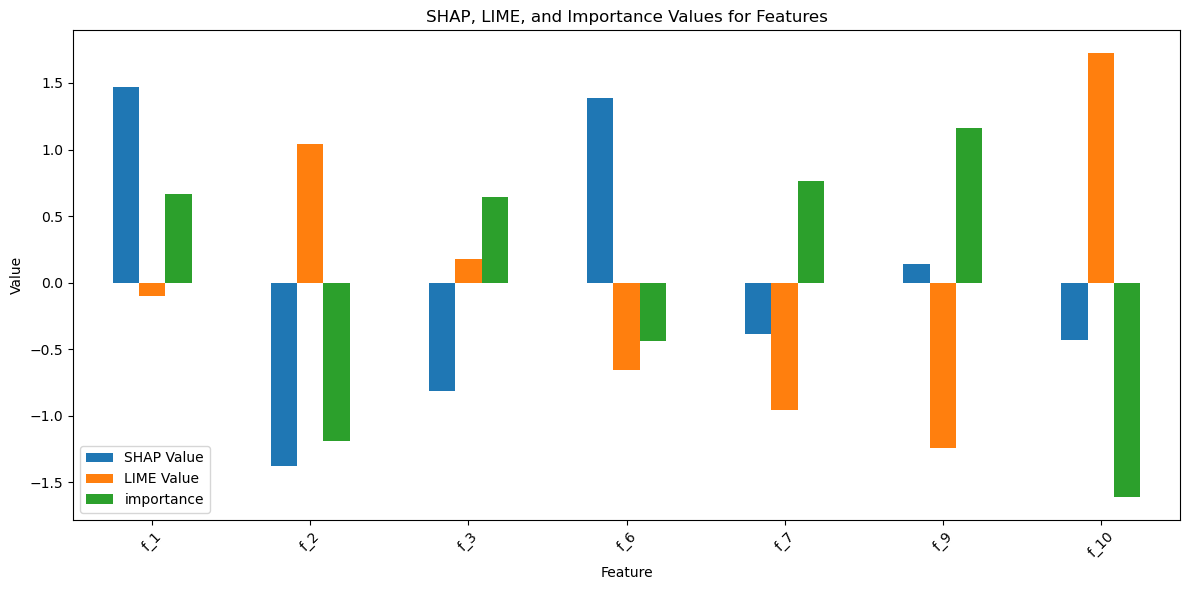

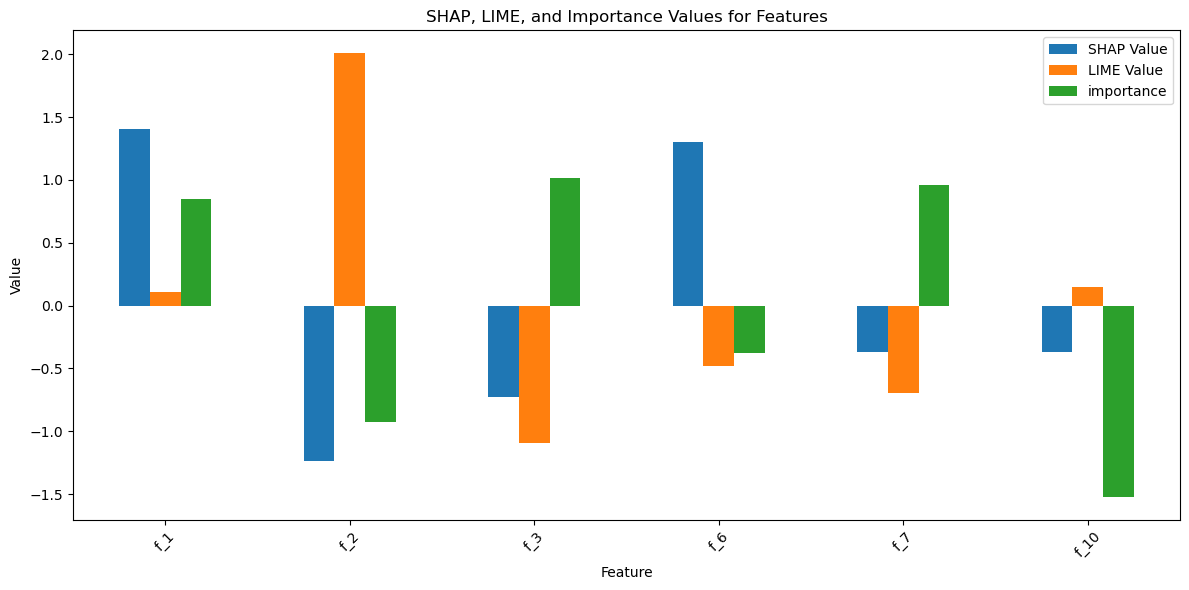

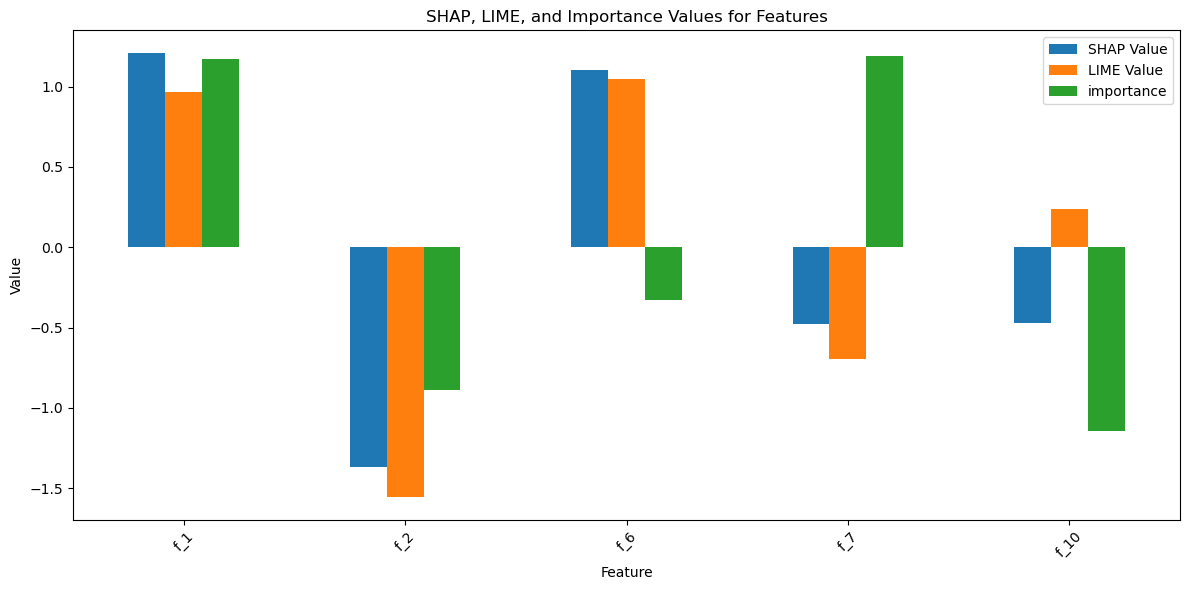

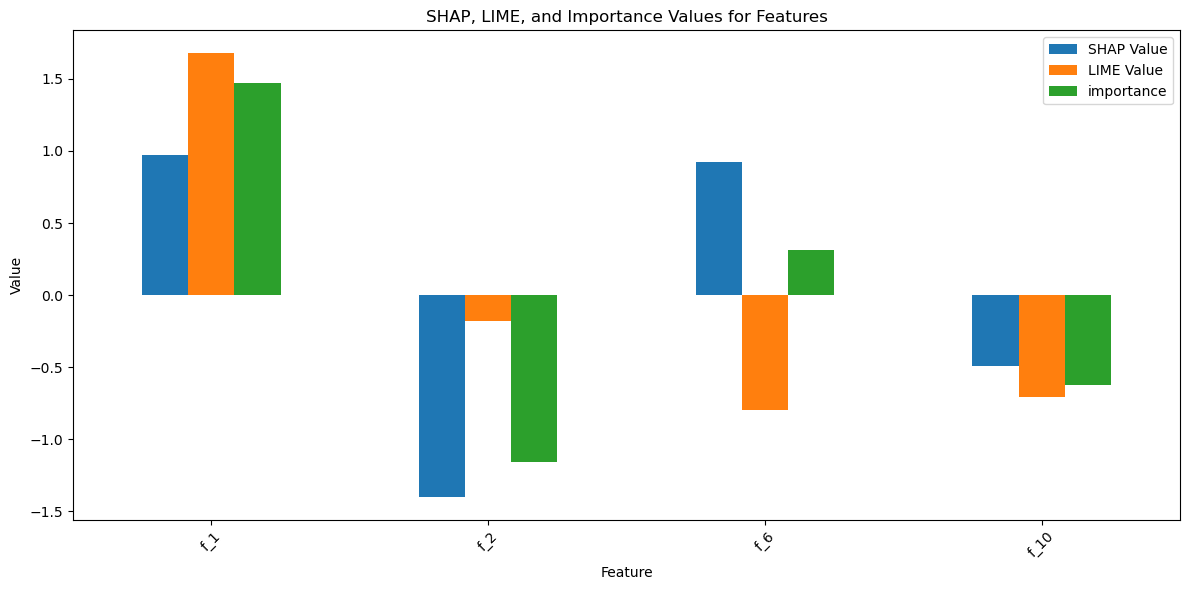

In [16]:
for rdf in results:
    plot_feat_importance(rdf)

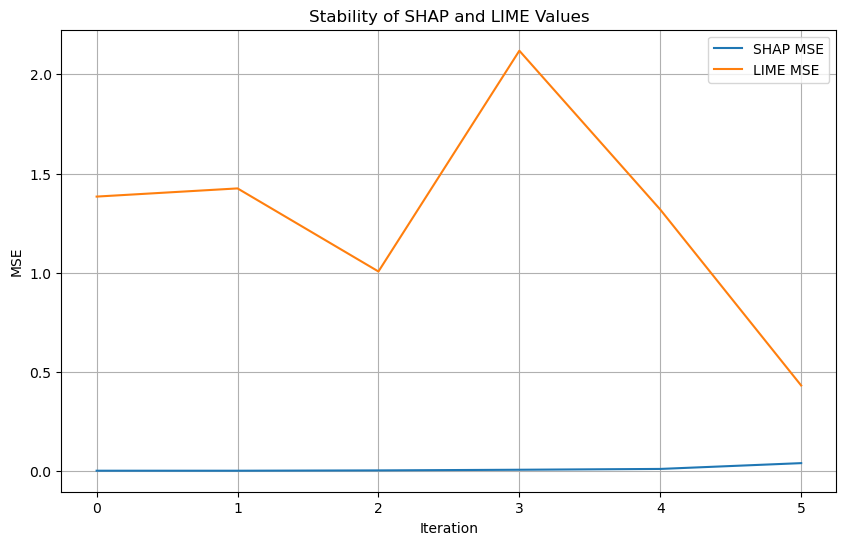

In [15]:
plot_mse(shap_mse_values, lime_mse_values)
